In [1]:
#Librerie utili nel programma
import agentpy as ap
import numpy as np
import random as rd
import math as mp
import matplotlib.pyplot as plt
import matplotlib as mpl
import IPython
import collections
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay
import csv


Il programma riportato in questo Notebook, è realizzato per simulare lo starlings flocking, tipico di molti uccelli.
Viene considerato come modello basilare il modello classico Boid, successivamente vengono aggiunte le formule per aggiornare le velocità di ogni singolo uccello ad ogni istante di tempo utilizzando le formule del modello di Cucker - Smale.

In [2]:
#Variabili utili nel programma
C=0.003
D3=0.0015
E3=0.0003
B1=0.1
D0=1
E0=1
P1=1
Y1=1
D1=5
E1=2.5
S1=1.047
S2=1.57
alpha=1
beta=1

time_step=1

In [3]:
#Normalize a vector to length 1.
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        return v
    return v / norm

In [4]:
#Funzione cutoff solo per S2
def cutoffS2(x,s2,s1):
    coss2=mp.cos(s2)
    coss1=mp.cos(s1)
    if x <= coss2:
        return 0
    elif coss2 < x <= coss1:
        return (1-cutoff(x,D0,E0))
    else:
        return 1

In [5]:
#Funzione cutoff per S0 e S1
def cutoff(x,d,e):
    if x <= d:
        return 1
    elif x < (d + e):
        return 0.5+0.5*np.tan((1/(x-d))+(1/(x-(d+e))))
    else:
        return 0

In [6]:
#Calcolo w per la velocità come da articolo
def w(x,y,v):
    w1=Y1/pow(1+pow(np.linalg.norm(x-y),2),B1)
    w2=cutoff(np.linalg.norm(v),D1,E1)
    w3=(1-w2)
    w4=(np.dot((y-x),v))/(np.linalg.norm(y-x)*np.linalg.norm(v))
    w5=(1-cutoff(w4,np.cos(S2),np.cos(S1) - np.cos(S2)))
    return w1*(w2+w3*w5)

La formula presa in considerazione dal modello Cucker - Smale per aggiornale la velocità è la seguente:
Vi = Ri + Ai + Bi + (α − β|vi|^2)vi
Nella funzione "update_velocity(self)" vengono eseguiti i calcoli di R,A,B e del coefficiente di attrito divisi nelle rispettive regole 1,2,3 e 4. 
Viene aggiunta una quinta regola per regolare la velocità degli uccelli quando raggiungono i bordi della scatola.
La posizione viene aggiornate successivamente in base alla velocità calcolata e alla posizione precedente.

Articolo di riferimento: *Analysis and simulations of a refined flocking and swarming model of Cucker-Smale type,Kinetic & Related Models,4,1,1,16,2011-1-1,Martial Agueh,Reinhard Illner,Ashlin Richardson,1937-5093_2011_1_1, swarming, particle model, kinetic equation.,Flocking* 

In [7]:
for i in range (10):
    print(rd.randint(-100,100)/100)

-0.52
0.37
-0.97
0.22
-0.22
-0.13
-0.82
0.84
0.87
0.37


In [8]:
# Classe per aggiornare le velocità come d'articolo e di conseguenza anche le posizioni

class Boid(ap.Agent):
    
    def setup(self):
        global velinit
        global l
        initvel=np.zeros(3)
        

        initvel[0] = rd.randint(-400, 400)/400
        initvel[1] = rd.randint(-400, 400)/400
        initvel[2] = rd.randint(-400, 400 )/400
            
        self.velocity=initvel
        velinit[l]=self.velocity
        l+=1
    def setup_pos(self, space):
        global posinit
        global l1
        
        theta = rd.random() * 2 * mp.pi
        phi = rd.random() * 2 * mp.pi
        R_big = 200
        r_small = 50
        
        self.space = space
        self.neighbors = space.neighbors
        initposition=np.zeros(3)
        initposition[0] = 500 + (R_big + r_small * mp.cos(theta))*mp.cos(phi)
        initposition[1] = 500 + (R_big + r_small * mp.cos(theta))*mp.sin(phi)
        initposition[2] = 500 + r_small * mp.sin(phi)
        space.positions[self]=initposition
        self.pos = space.positions[self]
        posinit[l1]=self.pos
        l1+=1
    def update_velocity(self):
        
        global u
        global vel2D
        global pos2D
        global vel3D
        global pos3D
        global step
        pos = self.pos
        ndim = self.p.ndim
        
        # Rule 1 - A
        nbs = self.neighbors(self, distance=100)
        nbs_len = len(nbs)
        nbs_pos_array = np.array(nbs.pos)
        nbs_vec_array = np.array(nbs.velocity)
    
        if nbs_len > 0:
            N=1/(nbs_len)
            somma=0
            
            for j in range (nbs_len):
                t1=(1-cutoff(np.linalg.norm(pos-nbs_pos_array[j]),D0,E0))
                t3=w(pos,nbs_pos_array[j],self.velocity)
                t4=(nbs_vec_array[j]-self.velocity)
                t = t1*t3*t4
                somma=somma+t
            v1=N*somma
            
        else:
            v1 = np.zeros(ndim)

        # Rule 2 - R
        if nbs_len > 0:
            N2=P1/(nbs_len)
            somma2=0
            for j in range (nbs_len):
                d1=cutoff(np.linalg.norm(pos-nbs_pos_array[j]),D0,E0)
                d2=(pos-nbs_pos_array[j])/(pow(1+pow(np.linalg.norm(pos-nbs_pos_array[j]),2),B1))
                d=d1*d2
                somma2=somma2+d
            v2=N2*somma2
              
        else:
            v2=np.zeros(ndim)

        # Rule 3 - B
        if nbs_len > 0:
            N3=1/(nbs_len)
            somma3=0
            if ndim == 3:
                velocity3=self.velocity
            else:
                velocity3=np.append(self.velocity,0)
            k=np.array([0,0,-1])
            for j in range (nbs_len):
                d3=1/(1+pow(np.linalg.norm(pos-nbs_pos_array[j]),2))
                somma3=somma3+d3
            pv3=N3*somma3
            v3=C*cutoff(pv3,D3,E3)*np.cross(velocity3,k)
            if ndim==2:
                v3=np.delete(v3,2)
            
        else:
            v3 = np.zeros(ndim)

        # Rule 4 - Attrito

        v4 = max((alpha-beta*pow(np.linalg.norm(self.velocity),2)) * np.linalg.norm(self.velocity), -(np.linalg.norm(self.velocity))/10) * self.velocity / np.linalg.norm(self.velocity)
      
        # Rule 5 - Borders
        v5 = np.zeros(ndim)
        d5 = self.p.border_distance
        s5 = self.p.border_strength
        for i in range(ndim):
            if pos[i] < d5:
                v5[i] += s5
            elif pos[i] > self.space.shape[i] - d5:
                v5[i] -= s5
       
        # Update velocity
        self.velocity += ( v1 + v2 + v3 + v4 + v5)*time_step
        #self.velocity = normalize(self.velocity)
        """
        vel3D = open("vel3D100classico_b02.txt", "a+")
        pos3D = open("pos3D100classico_b02.txt", "a+")
        vel3D.write(str(self.velocity[0]) + " " + str(self.velocity[1]) + " " + str(self.velocity[2]) + "\n")
        pos3D.write(str(pos[i][0]) + " " + str(pos[i][1]) + " " + str(pos[i][2]) + "\n")
        vel3D.close()
        pos3D.close()
        """
        
        if self.p.ndim == 2:
            vel2D[step][u]=self.velocity
            pos2D[step][u]=pos
        else:
            vel3D[step][u]=self.velocity
            pos3D[step][u]=pos  
        u+=1
        
        if u==self.p.population:
            u=0
            step+=1
            print(step)
    def update_position(self):

        self.space.move_by(self, self.velocity*time_step)

In [9]:
#Inizializzazione della classe del modello Boid
class BoidsModel(ap.Model):

    def setup(self):
        """ Initializes the agents and network of the model. """
        self.space = ap.Space(self, shape=[self.p.size] * self.p.ndim)
        self.agents = ap.AgentList(self, self.p.population, Boid)
        self.space.add_agents(self.agents, random=True)
        self.agents.setup_pos(self.space)

    def step(self):
        """ Defines the models' events per simulation step. """
        self.agents.update_velocity()  # Adjust direction
        self.agents.update_position()  # Move into new direction

In [10]:
#Funzioni per la visualizzazione delle immagini 2D e 3D
def animation_plot_single(m, ax):
    ndim = m.p.ndim
    ax.set_title(f"Boids Flocking Model {ndim}D t={m.t}")
    pos = m.space.positions.values()
    pos = np.array(list(pos)).T  # Transform
    ax.scatter(*pos, s=5, c='black')
    ax.set_xlim(0, m.p.size)
    ax.set_ylim(0, m.p.size)
    if ndim == 3:
        ax.set_zlim(0, m.p.size)
        ax.set_zlabel('z')
        #ax.set_zticklabels([])
    ax.grid()
    #ax.set_yticklabels([])
    #ax.set_xticklabels([])
    ax.set_ylabel('y')
    ax.set_xlabel('x')
def animation_plot(m, p):
    projection = '3d' if p['ndim'] == 3 else None
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111, projection=projection)
    animation = ap.animate(m(p), fig, ax, animation_plot_single)
    mpl.rcParams['animation.embed_limit'] = 100
    return IPython.display.HTML(animation.to_jshtml(fps=20))

Per visualizzare al meglio, sia in 2D e sia in 3D, il fenomeno starlings flocking vengono eseguiti 600 steps per 100 uccelli.

In [11]:
#Dichiaro parametri utili per la computazione 2D
parameters2D = {
    'size': 1000,
    'seed': 123,
    'steps': 100,
    'ndim': 2,
    'population': 100,
    'inner_radius': 3,
    'outer_radius': 10,
    'border_distance': 10,
    'border_strength': 5
}

In [13]:
#Computazione 3D con aggiornamenti parametri 2D e calcolo matrici velocità e posizioni 3D
new_parameters = {
    'ndim': 3,
    'population': 50,
    'wall_avoidance_distance': 5,
    'wall_avoidance_strength': 1
}

parameters3D = dict(parameters2D)
parameters3D.update(new_parameters)
l=0
l1=0
vicini=0
posizioni=0
spazio=0
step=0 #Tiene traccia numero step
u=0 #Tiene traccia numero uccelli
pos3D=np.zeros((parameters3D['steps'],parameters3D['population'],parameters3D['ndim']))
vel3D=np.zeros((parameters3D['steps'],parameters3D['population'],parameters3D['ndim']))
velinit=np.zeros((parameters3D['population'],parameters3D['ndim']))
posinit=np.zeros((parameters3D['population'],parameters3D['ndim']))
animation_plot(BoidsModel, parameters3D)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


Ora di seguito, vengono mostrati una serie di calcoli sulle velocità e posizioni calcolate e riportare nei file di testo.
Queste velocità e posizioni sono state calcolate per 1000 uccelli per 600 steps.

In [166]:
print(velinit)
print("---------------------------------------------------------------------------")
print(posinit)

[[-1.05  1.67 -1.21]
 [ 0.42 -0.67  1.51]
 [ 1.99 -1.71 -1.95]
 [-0.99 -0.75 -1.19]
 [-0.63 -0.09  1.53]
 [ 1.38 -1.4   0.98]
 [ 1.39  0.83 -1.36]
 [ 1.69  0.71  0.1 ]
 [-1.01  0.34 -0.03]
 [ 0.16 -0.33  0.64]
 [-1.29  0.07  0.79]
 [ 1.51 -0.66 -1.74]
 [ 1.16  1.37  1.79]
 [ 1.71  1.97  0.9 ]
 [ 0.08 -1.47 -1.02]
 [ 0.71 -1.36 -1.43]
 [ 0.39 -0.36  1.38]
 [ 1.2  -0.04 -1.36]
 [ 0.28 -0.38  0.02]
 [-1.65 -1.18 -0.57]
 [-0.12 -2.    0.07]
 [-1.42 -0.41 -1.8 ]
 [ 1.18 -1.86 -0.84]
 [-1.65 -0.14 -1.57]
 [ 0.3  -1.21 -0.57]
 [ 0.7   0.39 -0.57]
 [-0.53  0.42  0.81]
 [-1.91 -1.86  1.8 ]
 [-0.82  0.24  1.38]
 [-1.98  0.52  0.47]
 [-1.76 -0.54 -1.64]
 [ 1.29  0.75  0.73]
 [ 1.84  0.45 -1.83]
 [ 1.25 -0.08  1.07]
 [ 1.68 -0.11 -0.06]
 [-1.34  0.92 -1.13]
 [-0.27 -1.53 -1.86]
 [-1.15 -0.56  1.62]
 [-0.07 -1.7   0.9 ]
 [-1.63 -1.78 -1.64]
 [-1.   -1.8  -0.37]
 [-0.93  0.41 -0.28]
 [ 1.92  1.97 -0.23]
 [-0.39  1.74 -0.04]
 [ 1.59  1.71  0.9 ]
 [ 0.15  0.18  0.07]
 [-0.87 -0.53  0.04]
 [ 0.15 -0.18

In [109]:
print(vicini)

0


In [110]:
#Dichiaro nuove variabili utili ai calcoli fisici-matematici
uccelli=100
dim=3
step=197

In [111]:
#Per una maggiore precisione i calcoli vengono effettuati su 1000 uccelli x 600 step calcolati precedentemente
#E riporati all'interno di file txt che vengono letti in automatico dal programma

vel_file = open("vel3D1000.txt")
pos_file = open("pos3D1000.txt")
read_vel = csv.reader(vel_file, delimiter=" ")
read_pos = csv.reader(pos_file, delimiter=" ")
file_vel = []
file_pos = []

for row in read_vel:
    file_vel.append(row)

for row1 in read_pos:
    file_pos.append(row1)
    
#Trasformo ciò che ho letto nei file in matrici numpy
file_vel = np.array(file_vel,dtype=float)
file_pos = np.array(file_pos,dtype=float)

#Eseguo questo calcolo per prendere solo gli uccelli ad un certo step fissato
cont=step
i=0
data_vel = np.zeros((uccelli, 3))
data_pos = np.zeros((uccelli, 3))
fine=cont+uccelli

while cont < (fine):
   data_vel[i]=file_vel[cont]
   data_pos[i]=file_pos[cont]
   cont+=1
   i+=1

FileNotFoundError: [Errno 2] No such file or directory: 'vel3D1000.txt'

In [112]:
#Calcolo modulo velocità media per tutti gli uccelli e per un singolo step
sum1=np.sum(data_vel,axis=0)
mod1=np.linalg.norm(sum1)
Vmedia=mod1/uccelli
print(Vmedia)

NameError: name 'data_vel' is not defined

In [426]:
#Calcolo G come da articolo  per un singolo step
x0=np.mean(data_pos,axis=0)
diff=np.zeros((uccelli,dim))
for j in range (uccelli):
    diff[j]=np.linalg.norm(data_pos[j]-x0)
G=np.mean(diff,axis=0)
print(G[0])

7.46105373229543


In [417]:
#Calcolo M come da articolo per un singolo step
vett=np.zeros(uccelli)
minimo=100
for i in range (uccelli):
    for j in range (uccelli):
        if i != j:
            dif=np.linalg.norm(data_pos[i]-data_pos[j])
            if dif < minimo:
                minimo=dif
    vett[i]=minimo
    minimo=100
M=np.mean(vett,axis=0)
print(M)

1.1021063191863485


In [89]:
#Rappresentazione volume ad un certo step t
pts=initpos
hull = ConvexHull(pts)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "r-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))

plt.show()

QhullError: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1426947517  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 36  Error-roundoff 6.2e-14  _one-merge 4.4e-13
  _near-inside 2.2e-12  Visible-distance 1.2e-13  U-max-coplanar 1.2e-13
  Width-outside 2.5e-13  _wide-facet 7.5e-13  _maxoutside 5e-13

precision problems (corrected unless 'Q0' or an error)
      4 degenerate hyperplanes recomputed with gaussian elimination
      4 nearly singular or axis-parallel hyperplanes
      4 zero divisors during back substitute
      4 zero divisors during gaussian elimination

The input to qhull appears to be less than 3 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p2(v4):    34    37    20
- p1(v3):    37    41    20
- p0(v2):    40    45    20
- p9(v1):    13     9    20

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 6.2e-14.  The center point, facets and distances
to the center point are as follows:

center point       31       33       20

facet p1 p0 p9 distance= -3.6e-15
facet p2 p0 p9 distance= -3.6e-15
facet p2 p1 p9 distance= -3.6e-15
facet p2 p1 p0 distance= -3.6e-15

These points either have a maximum or minimum x-coordinate, or
they maximize the determinant for k coordinates.  Trial points
are first selected from points that maximize a coordinate.

The min and max coordinates for each dimension are:
  0:        13        40  difference=   27
  1:         9        45  difference=   36
  2:        20        20  difference=    0

If the input should be full dimensional, you have several options that
may determine an initial simplex:
  - use 'QJ'  to joggle the input and make it full dimensional
  - use 'QbB' to scale the points to the unit cube
  - use 'QR0' to randomly rotate the input for different maximum points
  - use 'Qs'  to search all points for the initial simplex
  - use 'En'  to specify a maximum roundoff error less than 6.2e-14.
  - trace execution with 'T3' to see the determinant for each point.

If the input is lower dimensional:
  - use 'QJ' to joggle the input and make it full dimensional
  - use 'Qbk:0Bk:0' to delete coordinate k from the input.  You should
    pick the coordinate with the least range.  The hull will have the
    correct topology.
  - determine the flat containing the points, rotate the points
    into a coordinate plane, and delete the other coordinates.
  - add one or more points to make the input full dimensional.


In [419]:
#Calcolo volume ad un certo step t
def tetrahedron_volume(a, b, c, d):
    return np.abs(np.einsum('ij,ij->i', a-d, np.cross(b-d, c-d))) / 6

dt = Delaunay(pts)
tets = dt.points[dt.simplices]
vol = np.sum(tetrahedron_volume(tets[:, 0], tets[:, 1], 
                                tets[:, 2], tets[:, 3]))
densita=uccelli/vol
print(densita)
print(vol)

0.03752208564914245
26650.970560397258


In [83]:
#Calcolo polarizzazione come d'articolo per un certo step
array=np.zeros((uccelli,dim))
for j in range (uccelli):
    norm = np.linalg.norm(data_vel[j])
    array[j] = data_vel[j] / norm
pol=np.linalg.norm(np.mean(array,axis=0))
print(pol)

NameError: name 'data_vel' is not defined

In [92]:
#Calcolo u = velocità singolo uccello - velocità media ad un certo step
velstep=vel3D[182,:,:]
U=np.zeros((uccelli,dim))
VelMedia=np.mean(velstep,axis=0)
for j in range (uccelli):
    U[j] = velstep[j] - VelMedia
    print(U[j])
        
#controllo che u sia uguale a zero
controll= np.round(np.sum(U,axis=0),2)
print(controll)

[-0.05752968  0.45233691 -0.34461529]
[-0.962407   -0.9832191  -0.00573532]
[ 0.02922475  0.05671071 -0.0240012 ]
[ 0.02185054  0.07719461 -0.00124312]
[ 0.02181409  0.07261396 -0.08953802]
[ 0.01083943 -0.10926597  0.0458812 ]
[-0.0092894   0.03074804 -0.02648488]
[ 0.03844391  0.0141679  -0.01775406]
[0.22732448 0.2146462  1.17890927]
[ 0.00559755  0.0971802  -0.03859018]
[0.01494617 0.07309319 0.019415  ]
[ 0.02439123  0.09286555 -0.09133832]
[0.02698613 0.03149594 0.00572503]
[ 0.00607522  0.10038831 -0.053339  ]
[ 0.02184045  0.06056038 -0.07658402]
[-0.10494038 -0.34405938 -0.33684239]
[ 0.01335252  0.10406103 -0.05922712]
[-0.00896102  0.11758801 -0.16063061]
[0.03845041 0.04188545 0.04695683]
[ 0.01979912  0.06200517 -0.00569273]
[ 0.02806505  0.62988442 -0.27036461]
[0.02239567 0.07133171 0.02482805]
[ 0.02320491  0.00440199 -0.01356678]
[-0.00155012 -0.01900002  0.0617377 ]
[ 0.01095699 -0.00690432  0.04822016]
[ 0.01328707  0.04676462 -0.00947676]
[0.00833632 0.00650462 0.03

In [93]:
#Funzione delta correlazione
def delta(sigma):
    if sigma == 0:
        return 1
    else:
        return 0
    
#Funzione correlazione C(r) per uno step
def correlation(r):
    velox=U
    posix=pos3D[182,:,:]
    som=0
    somDelta=0
    for i in range (uccelli):
        for j in range (uccelli):
            if i != j:
                modvi=np.linalg.norm(velox[i])
                modvj=np.linalg.norm(velox[j])
                si=velox[i]/modvi
                sj=velox[j]/modvj
                r1=np.round(np.linalg.norm(posix[i]-posix[j]),0)
                delt=delta(r-r1)
                somj=np.dot(si,sj)*delt
                som = som + somj
                somDelta = somDelta + delt
    if somDelta == 0:
        return 0
    else:
        return (som / somDelta)


In [94]:
#Calcolo valore correlazione per ogni r dell'array 
massimo = 35
r2 = np.arange(0,massimo,1)
cor = []
r = []
for i in range (r2.size):
    result = np.round(correlation(r2[i]),0)
    if result != 0:
        cor.append(result)
        r.append(r2[i])
    print(i)
cor=np.array(cor)
r=np.array(r)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


In [95]:
#Creao il grafico della cella di sopra
def grafico (r,cor):
    plt.plot(r, cor, marker = "o", color = 'red')
    plt.title("Grafico correlazione")
    plt.xlabel("R") 
    plt.ylabel("Correlation(R)")
    plt.show()

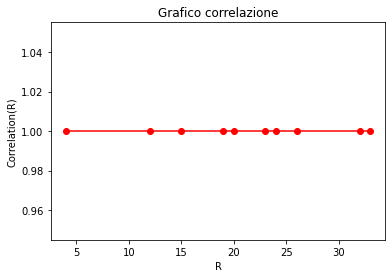

In [96]:
grafico(r,cor)

In [425]:
#Quantificazione dell'anisotropia dello stormo
position=data_pos
veloc=data_vel
mini=200
matrix=np.zeros((uccelli,3,3))
for i in range(uccelli):
    for j in range(uccelli):
        if i != j:
            val=np.linalg.norm(position[i]-position[j])
            if val < mini:
                j1=j
                mini=val
    ui=(veloc[i]/np.linalg.norm(veloc[i]))
    uj=(veloc[j1]/np.linalg.norm(veloc[j1]))
    matrix[i][0][0]=ui[0]*uj[0]
    matrix[i][0][1]=ui[0]*uj[1]
    matrix[i][0][2]=ui[0]*uj[2]
    matrix[i][1][0]=ui[1]*uj[0]
    matrix[i][1][1]=ui[1]*uj[1]
    matrix[i][1][2]=ui[1]*uj[2]
    matrix[i][2][0]=ui[2]*uj[0]
    matrix[i][2][1]=ui[2]*uj[1]
    matrix[i][2][2]=ui[2]*uj[2]
    mini=200

Mmedio=np.mean(matrix,axis=0)
autovalori, autovettori = np.linalg.eig(Mmedio)
low=min(autovalori)
index,=np.where(autovalori==low)
autovet=autovettori[index,:]
gamma=pow(autovet[0][0]*VelMedia[0]+autovet[0][1]*VelMedia[1]+autovet[0][2]*VelMedia[2],2)
print(gamma)


0.10587749009954968


In [ ]:
#Funzione correlazione C(r) per uno step, restituisce True con il rispettivo valore di r e C(r) quando la funzione di
#correlazione incrocia per la prima volta l'asse delle X ovvero C(r)=0.
def correlationY(r):
    velox=U
    posix=data_pos
    som=0
    somDelta=0
    for i in range (uccelli):
        for j in range (uccelli):
            if i != j:
                modvi=np.linalg.norm(velox[i])
                modvj=np.linalg.norm(velox[j])
                si=velox[i]/modvi
                sj=velox[j]/modvj
                r1=np.round(np.linalg.norm(posix[i]-posix[j]),0)
                delt=delta(r-r1)
                somj=np.dot(si,sj)*delt
                som = som + somj
                somDelta = somDelta + delt
    if somDelta == 0:
        return False,0,0
    elif np.round((som / somDelta),2)==0.00:
        return True,r,som/somDelta
    else:
        return False,0,0
    
#Calcolo valore correlazione per ogni r dell'array prendendo come rMin l'ultimo valore positivo e rMax il primo valore
#negativo per uno step di 0.05. Se C(r) restituisce True la funzione esce dal ciclo for e stampa i risultati
index,=np.where(cor<0)
minr3=r[index[0]-1]
maxr3=r[index[0]]
r3 = np.arange(minr3,maxr3,0.05)
i=0
flag = True
while i < (r3.size) and flag == True:
    result3 = correlationY(r3[i])
    if result3[0] == True:
        cor3=result3[2]
        R1=result3[1]
        flag = False;
    i+=1
    print(str(i) + ' - ' + str(flag))
print('Risultati:')
print(np.round(cor3,2))
print(R1)

1 - True


In [465]:
#Funzione correlazione C(r) per uno step, vengono considerate il modulo delle velocità di un singolo uccello - la velocità 
# media di tutti gli uccelli
def correlationMod(r):
    velox=data_vel
    posix=data_pos
    som=0
    somDelta=0
    for i in range (uccelli):
        for j in range (uccelli):
            if i != j:
                modvi=np.linalg.norm(velox[i])
                modvj=np.linalg.norm(velox[j])
                si=modvi-Vmedia
                sj=modvj-Vmedia
                r1=np.round(np.linalg.norm(posix[i]-posix[j]),2)
                delt=delta(r-r1)
                somj=si*sj*delt
                som = som + somj
                somDelta = somDelta + delt
    print(som/somDelta)
    
    if somDelta == 0:
        return 0
    else:
        return (som / somDelta)
    
#Calcolo valore correlazione del modulo delle velocità per ogni r dell'array 
r4 = np.arange(0,35,1)
corMod = []
rMod = []
for i in range (r4.size):
    result4 = np.round(correlationMod(r4[i]),3)
    if result4 != 0:
        print('siii')
        corMod.append(result4)
        rMod.append(r4[i])
    print(i)
corMod=np.array(corMod)
rMod=np.array(rMod)

0.0027504989601325014
siii
0
0.0027504989601325057
siii
1
0.0027504989601324914
siii
2
0.002750498960132514
siii
3
0.002750498960132522
siii
4
0.0027504989601325265
siii
5
0.002750498960132533
siii
6
0.0027504989601325365
siii
7
0.002750498960132538
siii
8
0.0027504989601325365
siii
9
0.0027504989601325348
siii
10
0.002750498960132532
siii
11
0.002750498960132525
siii
12
0.0027504989601325022
siii
13
0.0027504989601324957
siii
14
0.00275049896013249
siii
15
0.0027504989601325044
siii
16
0.002750498960132505
siii
17
0.0027504989601325
siii
18
0.002750498960132499
siii
19
0.002750498960132499
siii
20
0.0027504989601324988
siii
21
0.0027504989601324988
siii
22
0.0027504989601325014
siii
23
0.0027504989601325035
siii
24
0.0027504989601325
siii
25
0.0027504989601325
siii
26
0.002750498960132502
siii
27
0.0027504989601324996
siii
28
0.002750498960132502
siii
29
0.002750498960132502
siii
30
0.0027504989601325014
siii
31
0.0027504989601325022
siii
32
0.0027504989601325005
siii
33


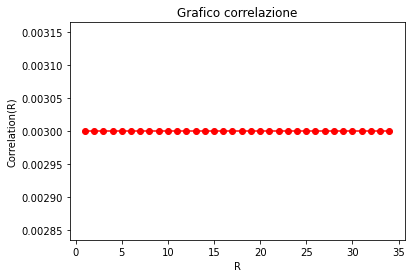

In [466]:
grafico(rMod,corMod)